In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import yaml

torch.set_float32_matmul_precision("medium")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Create Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


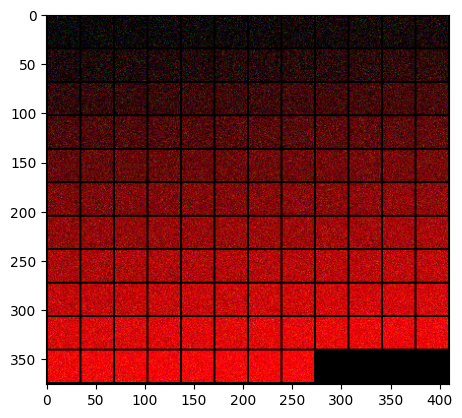

In [2]:
from pytorch_lightning import LightningDataModule
import torch
from torchvision.datasets import VisionDataset


class RedValuesDataset(VisionDataset):
    def __init__(self, N, img_dim):
        super(RedValuesDataset, self).__init__()
        self.N = N
        self.img_dim = img_dim
        self.data = torch.zeros([N, *img_dim])
        self.data[:, 0, ...] += torch.linspace(0.0, 1.0, N).reshape((N, 1, 1))
        random_noise = torch.randn_like(self.data) * 0.1  # Noise scale
        self.data += random_noise

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.data[idx], -1


class RedLT(LightningDataModule):

    def __init__(self, N, img_dim, batch_size):
        super().__init__()
        self.N = N
        self.img_dim = img_dim
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.dataset = RedValuesDataset(self.N, self.img_dim)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.dataset, batch_size=self.batch_size, shuffle=True
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.N)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.N)


# print("Mean/Std R Val", X[:, 0, ...].mean().item(), X[:, 0, ...].std().item())
# print("Mean/Std B Val", X[:, 1, ...].mean().item(), X[:, 1, ...].std().item())
# print("Mean/Std G Val", X[:, 2, ...].mean().item(), X[:, 2, ...].std().item())

plt.imshow(
    make_grid(RedValuesDataset(128, (3, 32, 32)).data, nrow=12)
    .permute(1, 2, 0)
    .cpu()
    .detach()
    .numpy()
)

# Load VAE model

In [3]:
from pytorch_lightning.loggers import TensorBoardLogger
from models import *
from experiment import VAEXperiment
import shutil
import os

config_path = "configs/red_vq_vae_defaultb.yaml"
with open(config_path, "r") as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

print(config)

tag = "_defaultb"
config_tagged = config_path.split("/")[-1].replace(".yaml", f"{tag}.yaml")
print(config_tagged)


tb_logger = TensorBoardLogger(
    save_dir=config["logging_params"]["save_dir"],
    name=config["logging_params"]["name"] + tag,
)

log_path = tb_logger.log_dir
print(log_path)
os.makedirs(log_path, exist_ok=True)
shutil.copy(config_path, log_path + "/" + config_tagged)

# For reproducibility
# seed_everything(config["exp_params"]["manual_seed"], True)

model = vae_models[config["model_params"]["name"]](**config["model_params"])
experiment = VAEXperiment(model, config["exp_params"])

{'model_params': {'name': 'VQVAE', 'in_channels': 3, 'embedding_dim': 128, 'num_embeddings': 512, 'img_size': 32, 'beta': 0.25}, 'exp_params': {'LR': 0.0001, 'weight_decay': 0.0, 'scheduler_gamma': 0.9999, 'kld_weight': 0.00025, 'manual_seed': 1265}, 'trainer_params': {'accelerator': 'gpu', 'devices': 1, 'max_epochs': 100000, 'check_val_every_n_epoch': 1000}, 'logging_params': {'save_dir': 'logs/', 'name': 'VQVAE_red_beta'}}
red_vq_vae_defaultb_defaultb.yaml
logs/VQVAE_red_beta_defaultb/version_3


In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from pytorch_lightning.plugins import DDPPlugin
from pathlib import Path
import os

runner = Trainer(
    logger=tb_logger,
    callbacks=[
        LearningRateMonitor(),
        ModelCheckpoint(
            save_top_k=1,
            dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
            monitor="Reconstruction_Loss",
            save_last=True,
        ),
    ],
    log_every_n_steps=1,
    # strategy=DDPPlugin(find_unused_parameters=False),
    **config["trainer_params"],
)


Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)
print(f"======= Training {config['model_params']['name']} =======")
img_dim = (3, 32, 32)

batch_size = 16
N = 128
runner.fit(experiment, datamodule=RedLT(N=N, img_dim=img_dim, batch_size=batch_size))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


======= Training VQVAE =======


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | VQVAE | 9.9 M 
--------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.638    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ducha/mambaforge/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/ducha/mambaforge/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/ducha/mambaforge/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
